In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf 
import keras_tuner as kt
from tensorflow.keras.models import load_model


df = pd.read_csv('../data/final_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) 
df.dropna(inplace=True)

# stock + technical indicators 
data = df[['Close', 'EMA_10', 'SMA_10', 'MACD', 'MACD_Signal', 'RSI', 'Open','High','Low', 'Volume']].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [5]:
def create_sequences(data, window_size):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size][0]) # Close price is the target
    return np.array(x), np.array(y)

window_size = 60 
x, y = create_sequences(scaled_data, window_size)

# split the data into training and testing sets
split = int(len(x)* 0.8) # 80% of 210 samples for training
x_train, x_test = x[:split], x[split:] 
y_train, y_test = y[:split], y[split:]

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],10)) #10 features
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 10))


Reloading Tuner from tuning_logs\indicators_lstm\tuner0.json
Best units: 64, dropout: 0.30000000000000004, learning_rate: 0.0033826843258466803
Epoch 1/30


c:\Users\priya\Downloads\stock-market-prediction\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 0.4067 - val_loss: 0.0271
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0599 - val_loss: 0.0225
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0252 - val_loss: 0.0340
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0194 - val_loss: 0.0135
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0243 - val_loss: 0.0170
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0175 - val_loss: 0.0285
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0185 - val_loss: 0.0151
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0136 - val_loss: 0.0280
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0168 - val_loss: 0.0161
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0131 - val_loss: 0.0172
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0121 - val_loss: 0.0176
Epoch 13/30

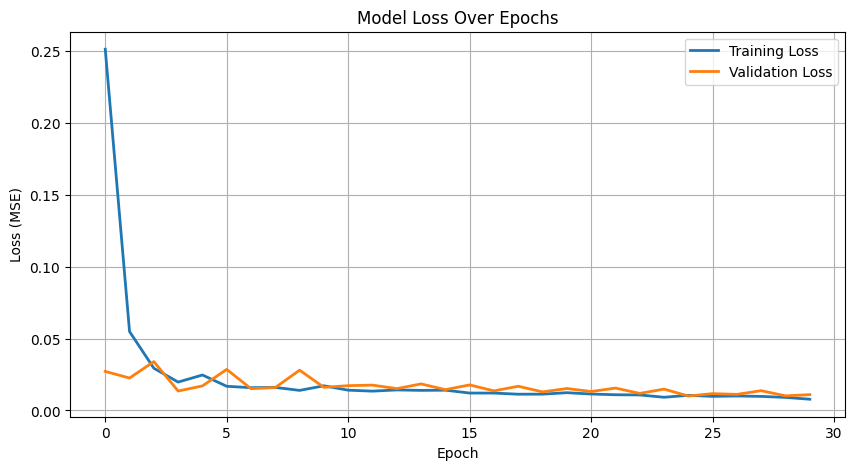

In [15]:
def build_model(hp):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.LSTM(
            units = hp.Int('units1', min_value=32, max_value=128, step=32), 
            return_sequences=True, 
            input_shape=(x_train.shape[1], x_train.shape[2])
    ))

    model.add(tf.keras.layers.Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(tf.keras.layers.LSTM(
            units = hp.Int('units2', min_value=32, max_value=128, step=32), 
            return_sequences=False
    ))
    
    model.add(tf.keras.layers.Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(1))    
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')        
        ), 
        loss='mean_squared_error'
    )
    
    return model

#Set up tuners for hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='indicators_lstm'
)

tuner.search(x_train, y_train, 
             epochs=30, 
             validation_data=(x_test, y_test), 
             batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units1')}, dropout: {best_hps.get('dropout1')}, learning_rate: {best_hps.get('learning_rate')}")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
#save the trained model
model.save('../models/indicators_final.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step
Root Mean Squared Error: 7.16
Mean Absolute Error: 5.94
R^2 Score: 0.41


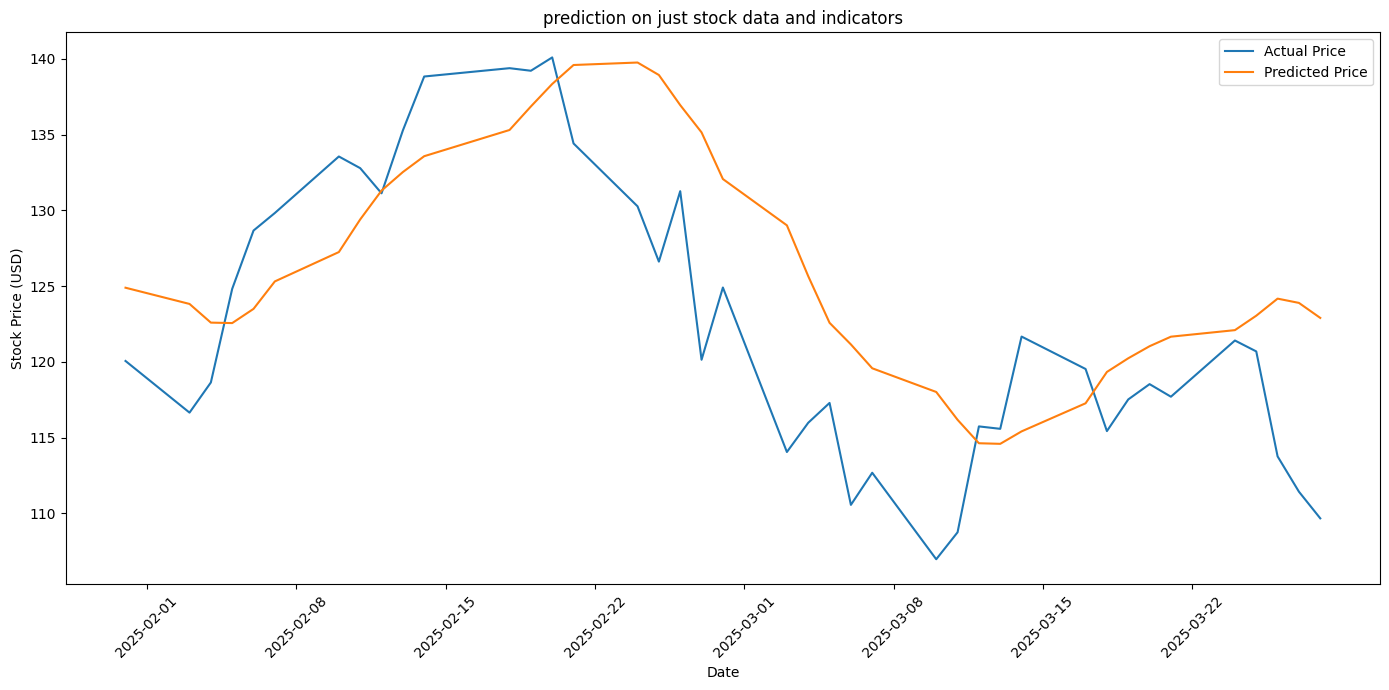

In [17]:

model = load_model("../models/indicators_final.keras")
predicted = model.predict(x_test) #predicting based on the test set

predicted_extended = np.zeros((predicted.shape[0], 10))
predicted_extended[:, 0] = predicted[:, 0]

actual_extended = np.zeros((y_test.shape[0], 10))
actual_extended[:, 0] = y_test

#Convert vals from scaled to normal
predicted_inversed = scaler.inverse_transform(predicted_extended)[:, 0]
actual_inversed = scaler.inverse_transform(actual_extended)[:, 0]

#Evaluation metrics
RMSE = root_mean_squared_error(actual_inversed, predicted_inversed)
MAE = mean_absolute_error(actual_inversed, predicted_inversed)  
R2 = r2_score(actual_inversed, predicted_inversed)

print(f'Root Mean Squared Error: {RMSE:.2f}')
print(f'Mean Absolute Error: {MAE:.2f}')    
print(f'R^2 Score: {R2:.2f}')

test_dates = df.index[-len(y_test):]

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test_dates, actual_inversed, label='Actual Price')
plt.plot(test_dates, predicted_inversed, label='Predicted Price')
plt.title('prediction on just stock data and indicators')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()